In [1]:
import torch
from torch import nn
from d2l import torch as d2l
from train_epoch.train import train_ch6

In [2]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [3]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [5]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [49]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

new models
training on cuda:0


Epoch 1/10: 100%|██████████| 60000/60000 [00:02<00:00, 23419.76img/s, loss=2.3102, train_acc=0.1136]


epoch 0, loss 2.310, train acc 0.114, test acc 0.204


Epoch 2/10: 100%|██████████| 60000/60000 [00:02<00:00, 22443.45img/s, loss=1.1936, train_acc=0.5265]


epoch 1, loss 1.194, train acc 0.527, test acc 0.647


Epoch 3/10: 100%|██████████| 60000/60000 [00:02<00:00, 22500.13img/s, loss=0.8153, train_acc=0.6804]


epoch 2, loss 0.815, train acc 0.680, test acc 0.719


Epoch 4/10: 100%|██████████| 60000/60000 [00:02<00:00, 23680.39img/s, loss=0.6894, train_acc=0.7284]


epoch 3, loss 0.689, train acc 0.728, test acc 0.720


Epoch 5/10: 100%|██████████| 60000/60000 [00:02<00:00, 22348.02img/s, loss=0.6271, train_acc=0.7547]


epoch 4, loss 0.627, train acc 0.755, test acc 0.753


Epoch 6/10: 100%|██████████| 60000/60000 [00:02<00:00, 22200.16img/s, loss=0.5764, train_acc=0.7766]


epoch 5, loss 0.576, train acc 0.777, test acc 0.778


Epoch 7/10: 100%|██████████| 60000/60000 [00:02<00:00, 23094.33img/s, loss=0.5318, train_acc=0.7952]


epoch 6, loss 0.532, train acc 0.795, test acc 0.789


Epoch 8/10: 100%|██████████| 60000/60000 [00:02<00:00, 23605.40img/s, loss=0.5000, train_acc=0.8116]


epoch 7, loss 0.500, train acc 0.812, test acc 0.806


Epoch 9/10: 100%|██████████| 60000/60000 [00:02<00:00, 22389.55img/s, loss=0.4764, train_acc=0.8217]


epoch 8, loss 0.476, train acc 0.822, test acc 0.812


Epoch 10/10: 100%|██████████| 60000/60000 [00:02<00:00, 22952.37img/s, loss=0.4566, train_acc=0.8310]


epoch 9, loss 0.457, train acc 0.831, test acc 0.819
loss 0.457, train acc 0.831, test acc 0.819
93319.6 examples/sec on cuda:0


In [2]:
import torch
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
            nn.Linear(120, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.Sigmoid(),
            nn.Linear(32, 10)
        )
    
    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        out = self.classifier(x2)
        return out
    
    def get_activations(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        return x1, x2
# Initialize the network
lenet = LeNet()


In [7]:
lr, num_epochs = 0.9, 20
train_ch6(lenet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu(),save_path="models/lenet")

# train_ch6(lenet, train_iter, test_iter, num_epochs, lr, d2l.try_gpu(),save_path="models/lenet",load_dir="models/lenet/best.ckpt")

new model
training on cuda:0


Epoch 1/20: 100%|██████████| 60000/60000 [00:02<00:00, 21543.52img/s, loss=0.8996, train_acc=0.6624]


epoch 0, loss 0.900, train acc 0.662


Epoch 2/20: 100%|██████████| 60000/60000 [00:02<00:00, 23017.86img/s, loss=0.4639, train_acc=0.8278]


epoch 1, loss 0.464, train acc 0.828


Epoch 3/20: 100%|██████████| 60000/60000 [00:02<00:00, 23408.21img/s, loss=0.3750, train_acc=0.8591]


epoch 2, loss 0.375, train acc 0.859
Saved best model checkpoint to models/lenet\0507235532\best.ckpt with test accuracy 0.841


Epoch 4/20: 100%|██████████| 60000/60000 [00:02<00:00, 22204.30img/s, loss=0.3406, train_acc=0.8727]


epoch 3, loss 0.341, train acc 0.873


Epoch 5/20: 100%|██████████| 60000/60000 [00:02<00:00, 22946.88img/s, loss=0.3083, train_acc=0.8831]


epoch 4, loss 0.308, train acc 0.883


Epoch 6/20: 100%|██████████| 60000/60000 [00:02<00:00, 22958.58img/s, loss=0.2919, train_acc=0.8892]


epoch 5, loss 0.292, train acc 0.889


Epoch 7/20: 100%|██████████| 60000/60000 [00:02<00:00, 22724.16img/s, loss=0.2829, train_acc=0.8928]


epoch 6, loss 0.283, train acc 0.893


Epoch 8/20: 100%|██████████| 60000/60000 [00:02<00:00, 22040.27img/s, loss=0.2624, train_acc=0.8998]


epoch 7, loss 0.262, train acc 0.900


Epoch 9/20: 100%|██████████| 60000/60000 [00:02<00:00, 23035.36img/s, loss=0.2508, train_acc=0.9058]


epoch 8, loss 0.251, train acc 0.906
Saved best model checkpoint to models/lenet\0507235532\best.ckpt with test accuracy 0.866


Epoch 10/20: 100%|██████████| 60000/60000 [00:02<00:00, 22085.15img/s, loss=0.2432, train_acc=0.9083]


epoch 9, loss 0.243, train acc 0.908


Epoch 11/20: 100%|██████████| 60000/60000 [00:02<00:00, 23379.60img/s, loss=0.2283, train_acc=0.9133]


epoch 10, loss 0.228, train acc 0.913


Epoch 12/20: 100%|██████████| 60000/60000 [00:02<00:00, 22800.37img/s, loss=0.2207, train_acc=0.9163]


epoch 11, loss 0.221, train acc 0.916
Saved best model checkpoint to models/lenet\0507235532\best.ckpt with test accuracy 0.872


Epoch 13/20: 100%|██████████| 60000/60000 [00:02<00:00, 22100.66img/s, loss=0.2159, train_acc=0.9181]


epoch 12, loss 0.216, train acc 0.918


Epoch 14/20: 100%|██████████| 60000/60000 [00:02<00:00, 23073.10img/s, loss=0.2052, train_acc=0.9229]


epoch 13, loss 0.205, train acc 0.923


Epoch 15/20: 100%|██████████| 60000/60000 [00:02<00:00, 23394.84img/s, loss=0.2043, train_acc=0.9216]


epoch 14, loss 0.204, train acc 0.922
Saved best model checkpoint to models/lenet\0507235532\best.ckpt with test accuracy 0.875


Epoch 16/20: 100%|██████████| 60000/60000 [00:02<00:00, 22562.12img/s, loss=0.1910, train_acc=0.9273]


epoch 15, loss 0.191, train acc 0.927


Epoch 17/20: 100%|██████████| 60000/60000 [00:02<00:00, 22325.69img/s, loss=0.1862, train_acc=0.9297]


epoch 16, loss 0.186, train acc 0.930


Epoch 18/20: 100%|██████████| 60000/60000 [00:02<00:00, 22873.79img/s, loss=0.1817, train_acc=0.9305]


epoch 17, loss 0.182, train acc 0.931


Epoch 19/20: 100%|██████████| 60000/60000 [00:02<00:00, 22727.23img/s, loss=0.1797, train_acc=0.9314]


epoch 18, loss 0.180, train acc 0.931


Epoch 20/20: 100%|██████████| 60000/60000 [00:02<00:00, 23171.17img/s, loss=0.1720, train_acc=0.9356]


epoch 19, loss 0.172, train acc 0.936
loss 0.172, train acc 0.936, test acc 0.886
88142.4 examples/sec on cuda:0


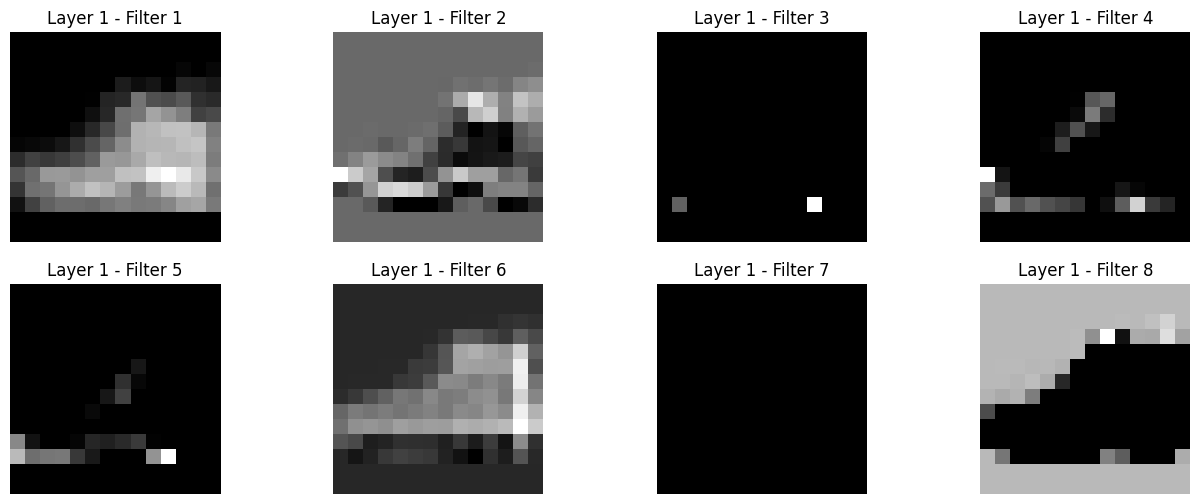

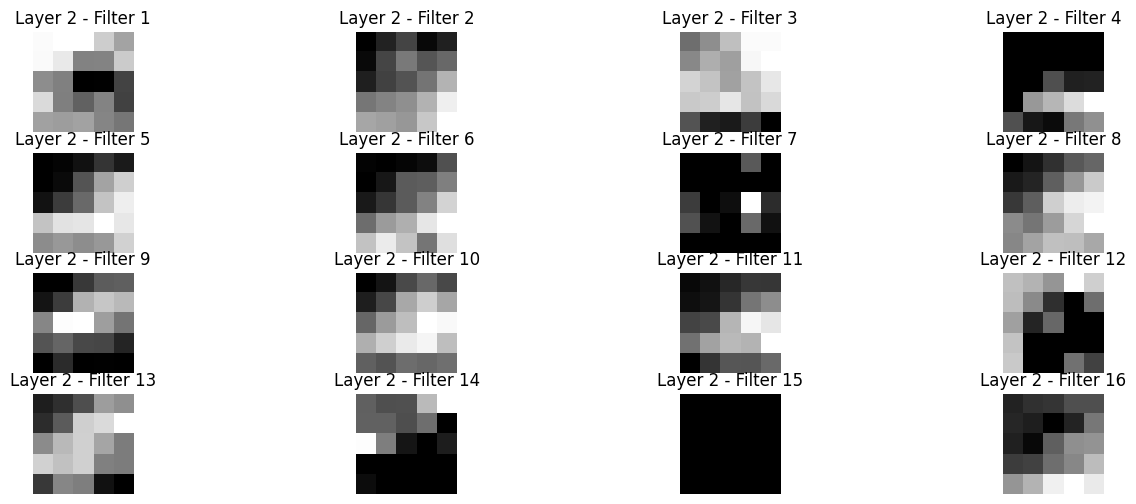

In [58]:
import matplotlib.pyplot as plt

def visualize_activations(net, device, dataloader):
    net.to(device)
    net.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            activations1, activations2 = net.get_activations(X)
            # 只显示一个批次中的第一个样本的激活
            act1 = activations1[0].cpu()
            act2 = activations2[0].cpu()
            break  # We only need one batch for visualization
    
    # 可视化第一层的激活
    plt.figure(figsize=(16, 6))
    for i in range(8):  # 假设第一层有8个过滤器
        plt.subplot(2, 4, i + 1)
        plt.imshow(act1[i].numpy(), cmap='gray')
        plt.title(f'Layer 1 - Filter {i+1}')
        plt.axis('off')
    plt.show()

    # 可视化第二层的激活
    plt.figure(figsize=(16, 6))
    for i in range(16):  # 假设第二层有16个过滤器
        plt.subplot(4, 4, i + 1)
        plt.imshow(act2[i].numpy(), cmap='gray')
        plt.title(f'Layer 2 - Filter {i+1}')
        plt.axis('off')
    plt.show()

# 假设你已经有了一个数据加载器
visualize_activations(lenet, 'cuda', test_iter)


In [54]:
def visualize_incorrect_predictions(model, dataloader, device, classes, num_images=5):
    model.eval()
    model.to(device)
    incorrect_count = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            
            # 检查预测是否正确
            incorrect_indices = (predicted != target).nonzero(as_tuple=False).squeeze()
            for idx in incorrect_indices:
                if incorrect_count >= num_images:
                    return
                plt.figure(figsize=(3, 3))
                image = data[idx].cpu().numpy().transpose((1, 2, 0))
                true_label = classes[target[idx].item()]
                predicted_label = classes[predicted[idx].item()]
                
                plt.imshow(image, cmap="gray")
                plt.title(f"True: {true_label}, Pred: {predicted_label}")
                plt.axis('off')
                plt.show()
                
                incorrect_count += 1


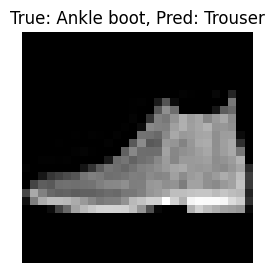

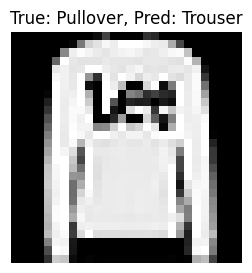

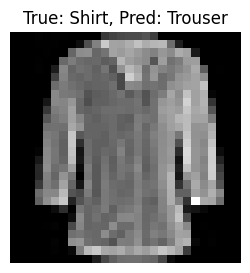

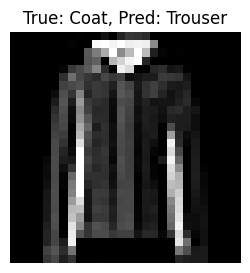

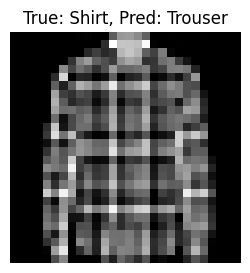

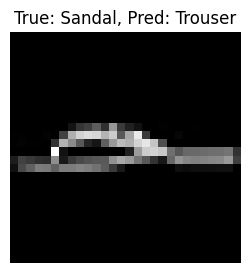

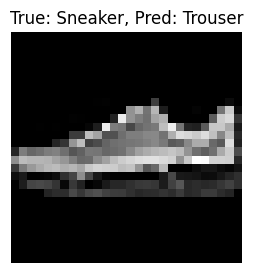

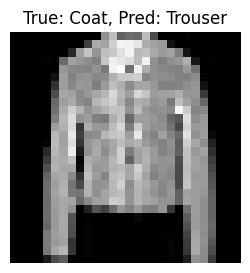

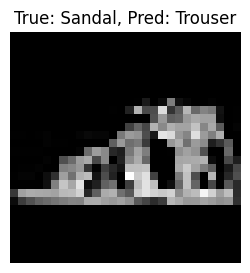

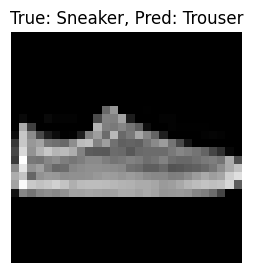

In [59]:
# 假设类别标签如下
classes = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]# 等等

# 调用函数
visualize_incorrect_predictions(lenet, test_iter, 'cuda', classes, num_images=10)
